# Lab : Using Convolutional Neural Networks (CNN) to identify Images

In this lab, we are going to setup a CNN to classify CIFAR dataset

References
- https://www.tensorflow.org/tutorials/images/cnn
- https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb

## About CIFAR Data

* CIFFAR-10 dataset consists of
    - 60,000 color images
    - 32x32 pixels, color
    - 10 classes (6,000 per class)
* 50,000 training images; 10,000 test images
* 5 training batches, 1 test batch
    - 10,000 images per batch  
    - Each batch has 1000 random images from each class
* **Size ~160 MB**


<img src="https://elephantscale-public.s3.amazonaws.com/media/CIFAR-10-dataset.png" />

In [1]:
## Determine if we are running on google colab

try:
    import google.colab
    RUNNING_IN_COLAB = True
except:
    RUNNING_IN_COLAB = False

print ("Running in Google COLAB : ", RUNNING_IN_COLAB)

Running in Google COLAB :  False


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

## Step 1: Download Data

In [3]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


print("train_images shape : ", train_images.shape)
print("train_labels shape : ", train_labels.shape)
print("test_images shape : ", test_images.shape)
print("test_labels shape : ", test_labels.shape)

train_images shape :  (50000, 32, 32, 3)
train_labels shape :  (50000, 1)
test_images shape :  (10000, 32, 32, 3)
test_labels shape :  (10000, 1)


## Step 2: Data Exploration

### Print out some random image

Displaying train index =  12517
train label [12517] = 3 = cat
------------ raw data for train_image[12517] -------
--------------------


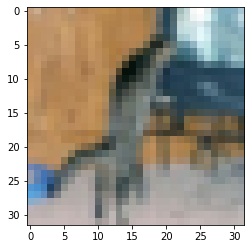

In [4]:
## Run this cell a few times to randomly display some digit data

import matplotlib.pyplot as plt
import random

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

index = random.randint(0, len(train_images))
# index = 10
print ("Displaying train index = ", index)

print("train label [{}] = {} = {}".format(index, train_labels[index][0], class_names[train_labels[index][0]]))
print ("------------ raw data for train_image[{}] -------".format(index))
# print(train_images[index])
print ("--------------------")

plt.imshow(train_images[index])

### Print out some samples

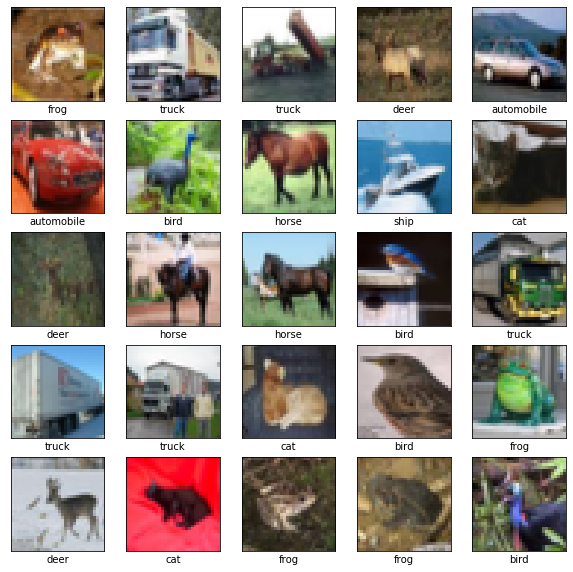

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Step 3 : Shape Data

### 3.1 - Normalize Data

Each pixel is a value from 0 to 255  
We are going to normalize them in the range of 0 to 1

In [6]:
## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

## Step 4 : Create Model

### 4.1 - Create a CNN

The code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to our first layer..

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________
None


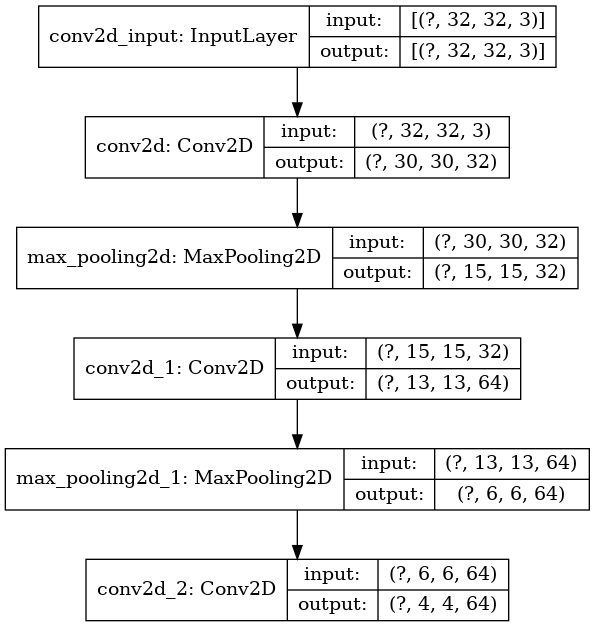

In [7]:

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

print (model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### 4.2 - Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

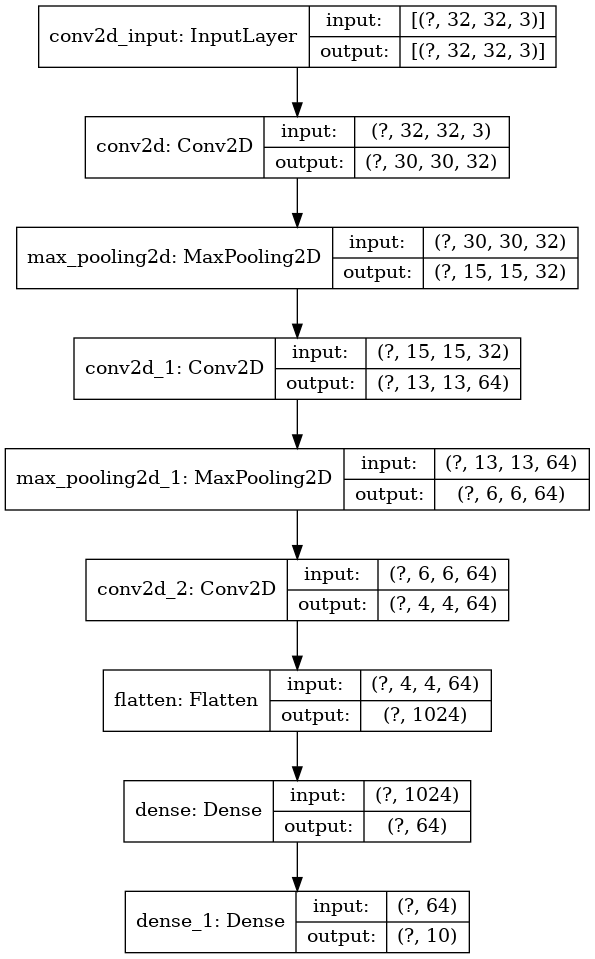

In [8]:
## TODO : complete the CNN
##   - First Dense layer = 64 neurons
##   - Last layer = 10 neurons and actuvation=tf.nn.softmax

## Questions
##   - why does last layer has 10 neurons?
##   - why is the last activation function SoftMax instead of ReLU?

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

print(model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

### 4.3 - Compile

In [9]:
# loss='sparse_categorical_crossentropy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

model.compile(optimizer=tf.keras.optimizers.Adam(),  # 'adam'
              loss=loss,
              metrics=['accuracy'])

## Step 5 - Setup Tensorboard

In [10]:
## This is fairly boiler plate code

import datetime
import os

app_name = 'cnn-cifar' # you can change this, if you like

tb_top_level_dir= '/tmp/tensorboard-logs'
tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name, 
                                    datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))
print ("Saving TB logs to : " , tensorboard_logs_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_dir, histogram_freq=1)

# Loading of tensorboard in Colab
if RUNNING_IN_COLAB:
    %load_ext tensorboard
    %tensorboard --logdir $tb_top_level_dir


Saving TB logs to :  /tmp/tensorboard-logs/cnn-cifar/2020-03-17--23-29-37


## Step 6 : Train

In [11]:
%%time

epochs = 10

print ("training starting ...")
history = model.fit(train_images, train_labels, 
                    epochs=epochs, validation_split = 0.2, verbose=1,
                    callbacks=[tensorboard_callback])
print ("training done.")

training starting ...
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 57s 1ms/sample - loss: 2.1005 - accuracy: 0.3521 - val_loss: 2.0200 - val_accuracy: 0.4360
Epoch 2/10
40000/40000 [==============================] - 52s 1ms/sample - loss: 1.9971 - accuracy: 0.4593 - val_loss: 1.9732 - val_accuracy: 0.4828
Epoch 3/10
40000/40000 [==============================] - 57s 1ms/sample - loss: 1.9478 - accuracy: 0.5102 - val_loss: 1.9254 - val_accuracy: 0.5347
Epoch 4/10
40000/40000 [==============================] - 44s 1ms/sample - loss: 1.9128 - accuracy: 0.5457 - val_loss: 1.9176 - val_accuracy: 0.5418
Epoch 5/10
40000/40000 [==============================] - 56s 1ms/sample - loss: 1.8883 - accuracy: 0.5703 - val_loss: 1.9000 - val_accuracy: 0.5570
Epoch 6/10
40000/40000 [==============================] - 55s 1ms/sample - loss: 1.8622 - accuracy: 0.5969 - val_loss: 1.8959 - val_accuracy: 0.5619
Epoch 7/10
40000/40000 [==========

## Step 7 : See Training History

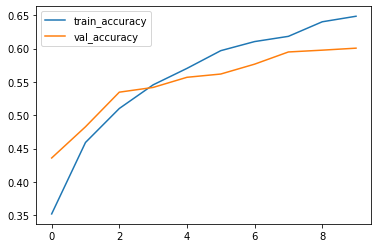

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Step 8 - Predict

**==> Compare prediction time vs training time.  Prediction is very quick!**

In [13]:
%%time 

print ("predicting on {:,} images".format(len(test_images)))
predictions = model.predict(test_images)


predicting on 10,000 images
CPU times: user 10.5 s, sys: 12.9 s, total: 23.4 s
Wall time: 1.7 s


random index =  5188
test_label[5188] = [8].  So the number is [8]
prediction of test_image[5188] = [ 0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000]
max softmax output =  0.99885905
index of max softmax output = 8.  So the prediction is same (8)


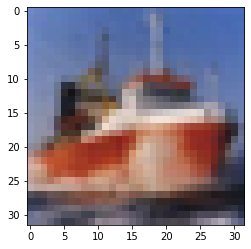

In [15]:
## Print a sample prediction

%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from pprint import pprint

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

index = random.randint(0, len(test_images))

print ("random index = ", index)
print ("test_label[{}] = {}.  So the number is {}".format(index, test_labels[index], test_labels[index]))
print ("prediction of test_image[{}] = {}".format(index, predictions[index]))
print ('max softmax output = ', np.amax(predictions[index]))
print ('index of max softmax output = {}.  So the prediction is same ({})'.format(np.argmax(predictions[index]), np.argmax(predictions[index])))

plt.imshow(test_images[index])

## Step 9 : Evaluate the Model 

### 9.1 - Metrics

In [16]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)

metrics = model.evaluate(test_images, test_labels, verbose=0)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.3f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'accuracy']
Metric : loss = 1.859
Metric : accuracy = 0.599


### 9.2 - Confusion Matrix

In [17]:
## our predictions is an array of arrays
print('predictions shape : ', predictions.shape)
print ('prediction 0 : ' , predictions[0])
print ('prediction 1 : ' , predictions[1])

predictions shape :  (10000, 10)
prediction 0 :  [ 0.000  0.000  0.000  0.973  0.000  0.027  0.000  0.000  0.001  0.000]
prediction 1 :  [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]


In [18]:
## We need to find the final output (max of softmax probabilities for each prediction)
predictions2 = [ np.argmax(p) for p in predictions]
print ('prediction2 0 : ' , predictions2[0])
print ('prediction2 1 : ' , predictions2[1])

prediction2 0 :  3
prediction2 1 :  8


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions2, labels = [0,1,2,3,4,5,6,7,8,9])
cm

array([[759,  31,  12,  18,  15,   5,   6,  12, 126,  16],
       [ 52, 791,   4,   5,   7,   2,   5,  10,  84,  40],
       [179,  18, 304,  82, 157,  68,  57,  65,  58,  12],
       [ 75,  28,  25, 430, 102, 131,  17, 114,  45,  33],
       [ 81,  15,  28,  69, 548,  28,  30, 174,  21,   6],
       [ 33,  10,  42, 186,  72, 465,   8, 144,  22,  18],
       [ 31,  44,  27, 153,  96,  26, 538,  33,  17,  35],
       [ 45,   8,   8,  42,  61,  49,   5, 760,  11,  11],
       [ 92,  38,   2,  16,   5,   5,   2,   6, 816,  18],
       [ 79, 189,   5,  18,   6,   7,   8,  32,  82, 574]])

index <> category mapping:
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


[]

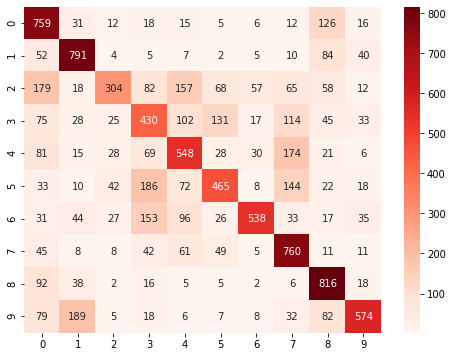

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

print ("index <> category mapping:")
for index, value in enumerate(class_names): 
    print(index, value) 

plt.figure(figsize = (8,6))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

### 9.3 - Metrics Calculated from Confusion Matrix

In [26]:
from sklearn.metrics import classification_report
from pprint import pprint

pprint(classification_report(test_labels, predictions2, output_dict=True))

{'0': {'f1-score': 0.6257213520197856,
       'precision': 0.532258064516129,
       'recall': 0.759,
       'support': 1000},
 '1': {'f1-score': 0.7283609576427255,
       'precision': 0.6749146757679181,
       'recall': 0.791,
       'support': 1000},
 '2': {'f1-score': 0.41729581331503085,
       'precision': 0.6652078774617067,
       'recall': 0.304,
       'support': 1000},
 '3': {'f1-score': 0.4259534422981674,
       'precision': 0.42198233562315995,
       'recall': 0.43,
       'support': 1000},
 '4': {'f1-score': 0.5297245045915902,
       'precision': 0.5126286248830683,
       'recall': 0.548,
       'support': 1000},
 '5': {'f1-score': 0.5207166853303472,
       'precision': 0.5916030534351145,
       'recall': 0.465,
       'support': 1000},
 '6': {'f1-score': 0.6420047732696897,
       'precision': 0.7958579881656804,
       'recall': 0.538,
       'support': 1000},
 '7': {'f1-score': 0.6468085106382978,
       'precision': 0.562962962962963,
       'recall': 0.76,
   

## Step 10 : Improve the Model

Try the following exercises

**1 - Increase epochs**  
- In Step-6, increase epochs to 10
- Rerun the notebook
- did the accuracy improve?
- how much the training time go up?